# Level-2 Soil Moisture (SM) algorithm performance assessment

This notebook implements a performance assessment of a prototype Level-2 Soil Moisture algorithm for CIMR. The assessment is based on a synthetic soil moisture test card, which is described in the algorithm implementation notebook. Only soil moisture retrievals are assessed, since soil moisture is the target variable of the algorithm.

Two performance metrics are considered: The unbiased RMSE (ubRMSE) and bias. The metrics are calculated for four AOIs that represent distinct land use and vegetation cover conditions. Soil moisture retrievals are assessed at the 36 km scale (L-band only) and at the 9 km scale (L-band sharpened with C-band).

## 1. Load the L2 datasets and reference data

In [1]:
# imports
from importlib import reload
import sys
import os
import numpy as np
import xarray as xr
import pyresample as pr
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pyresample import parse_area_file

# define dirs
basedir, algodir = os.path.split(os.path.abspath(''))
algopath = os.path.join(basedir, algodir, 'sm_algo')
toolpath = os.path.join(basedir, algodir, 'tools')
datapath = os.path.join(basedir, 'data')

# add dirs to sys
if algopath not in sys.path:
    sys.path.insert(0, algopath)
if toolpath not in sys.path:
    sys.path.insert(0, toolpath)
    
# import DEVALGO SM module
import sm_algo.sm_evaluation as sm_eval
import sm_algo.sm_resampling as resample


### 1.1. Load the L2 Files

A total of eight L2 files are loaded, corresponding to four independent CIMR L2 retrievals at the 36 km and 9 km scales, respectively. 

In [32]:
# 36 km
l2_36_deimos_asc = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-360_deimos_asc.nc'))
l2_36_deimos_des = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-360_deimos_des.nc'))
l2_36_sceps_asc = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-360_sceps_asc.nc'))
l2_36_sceps_des = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-360_sceps_des.nc'))

# 9 km
l2_09_deimos_asc = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-090_deimos_asc.nc'))
l2_09_deimos_des = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-090_deimos_des.nc'))
l2_09_sceps_asc = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-090_sceps_asc.nc'))
l2_09_sceps_des = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-090_sceps_des.nc'))


### 1.2. Load the test card as reference

We load the test card and aggregate the soil moisture reference to the 36 km and 9 km global EASE2 grids. 

In [7]:
# Import soil moisture Testcard
file_testcard = 'DEVALGO_testcard_soil_moisture_coastlines.nc'
testcard = xr.open_dataset(os.path.join(datapath, 'TC', file_testcard))

# initialize
tc_36 = {}
tc_09 = {}

# compute dominant land use (lu) and water fraction (wf) at 36 km and 9 km resolutions
tc_36['lu'], tc_36['wf'] = resample.testcard_compute_lu_wf(testcard['Land Use'].data, 36)
tc_09['lu'], tc_09['wf'] = resample.testcard_compute_lu_wf(testcard['Land Use'].data, 9)
# average Soil Moisture and L-band TBs at 36 km and 9 km (used later for comparison and plotting)
tc_36['Soil Moisture'] = testcard['Soil Moisture'].coarsen(dim={'n_row': 36, 'n_col': 36}, boundary='trim').mean().data
tc_09['Soil Moisture'] = testcard['Soil Moisture'].coarsen(dim={'n_row': 9, 'n_col': 9}, boundary='trim').mean().data
# set values over water to nan
tc_36['Soil Moisture'][tc_36['lu'] == 5] = np.nan                                 
tc_09['Soil Moisture'][tc_09['lu'] == 5] = np.nan                              
tc_36['Soil Moisture'][tc_36['wf'] > 0.5] = np.nan                             
tc_09['Soil Moisture'][tc_09['wf'] > 0.5] = np.nan                         


## 2. Evaluation

### 2.1. Soil moisture retrievals at the 36 km grid

We show the DEVALGO soil moisture retrievals and errors (error = retrieval - reference) at the 36 km grid. We find that the retrievals are generally in good agreement with the reference, particularly for the AOIs. 

Several observations apply to explain the error patterns across the test card. The largest errors occur at coastlines, which is expected due to spillover effects from the adjacent ocean TBs. Large errors also occur at the edge of the DEIMOS scenes, which is a spillover effect from the background fields used in the L1B simulations. Forest retrievals show notable biases, which is related to the dense vegetation masking the soil signal. For the same reason, instrument noise effects in the SCEPS scenes are particularly visible for forest retrievals (instrument noise is not considered in the DEIMOS scenes). The results are overall consistent across overpasses.

An assessment of ubRMSE and bias metrics for the four AOIs is given in section 2.4.

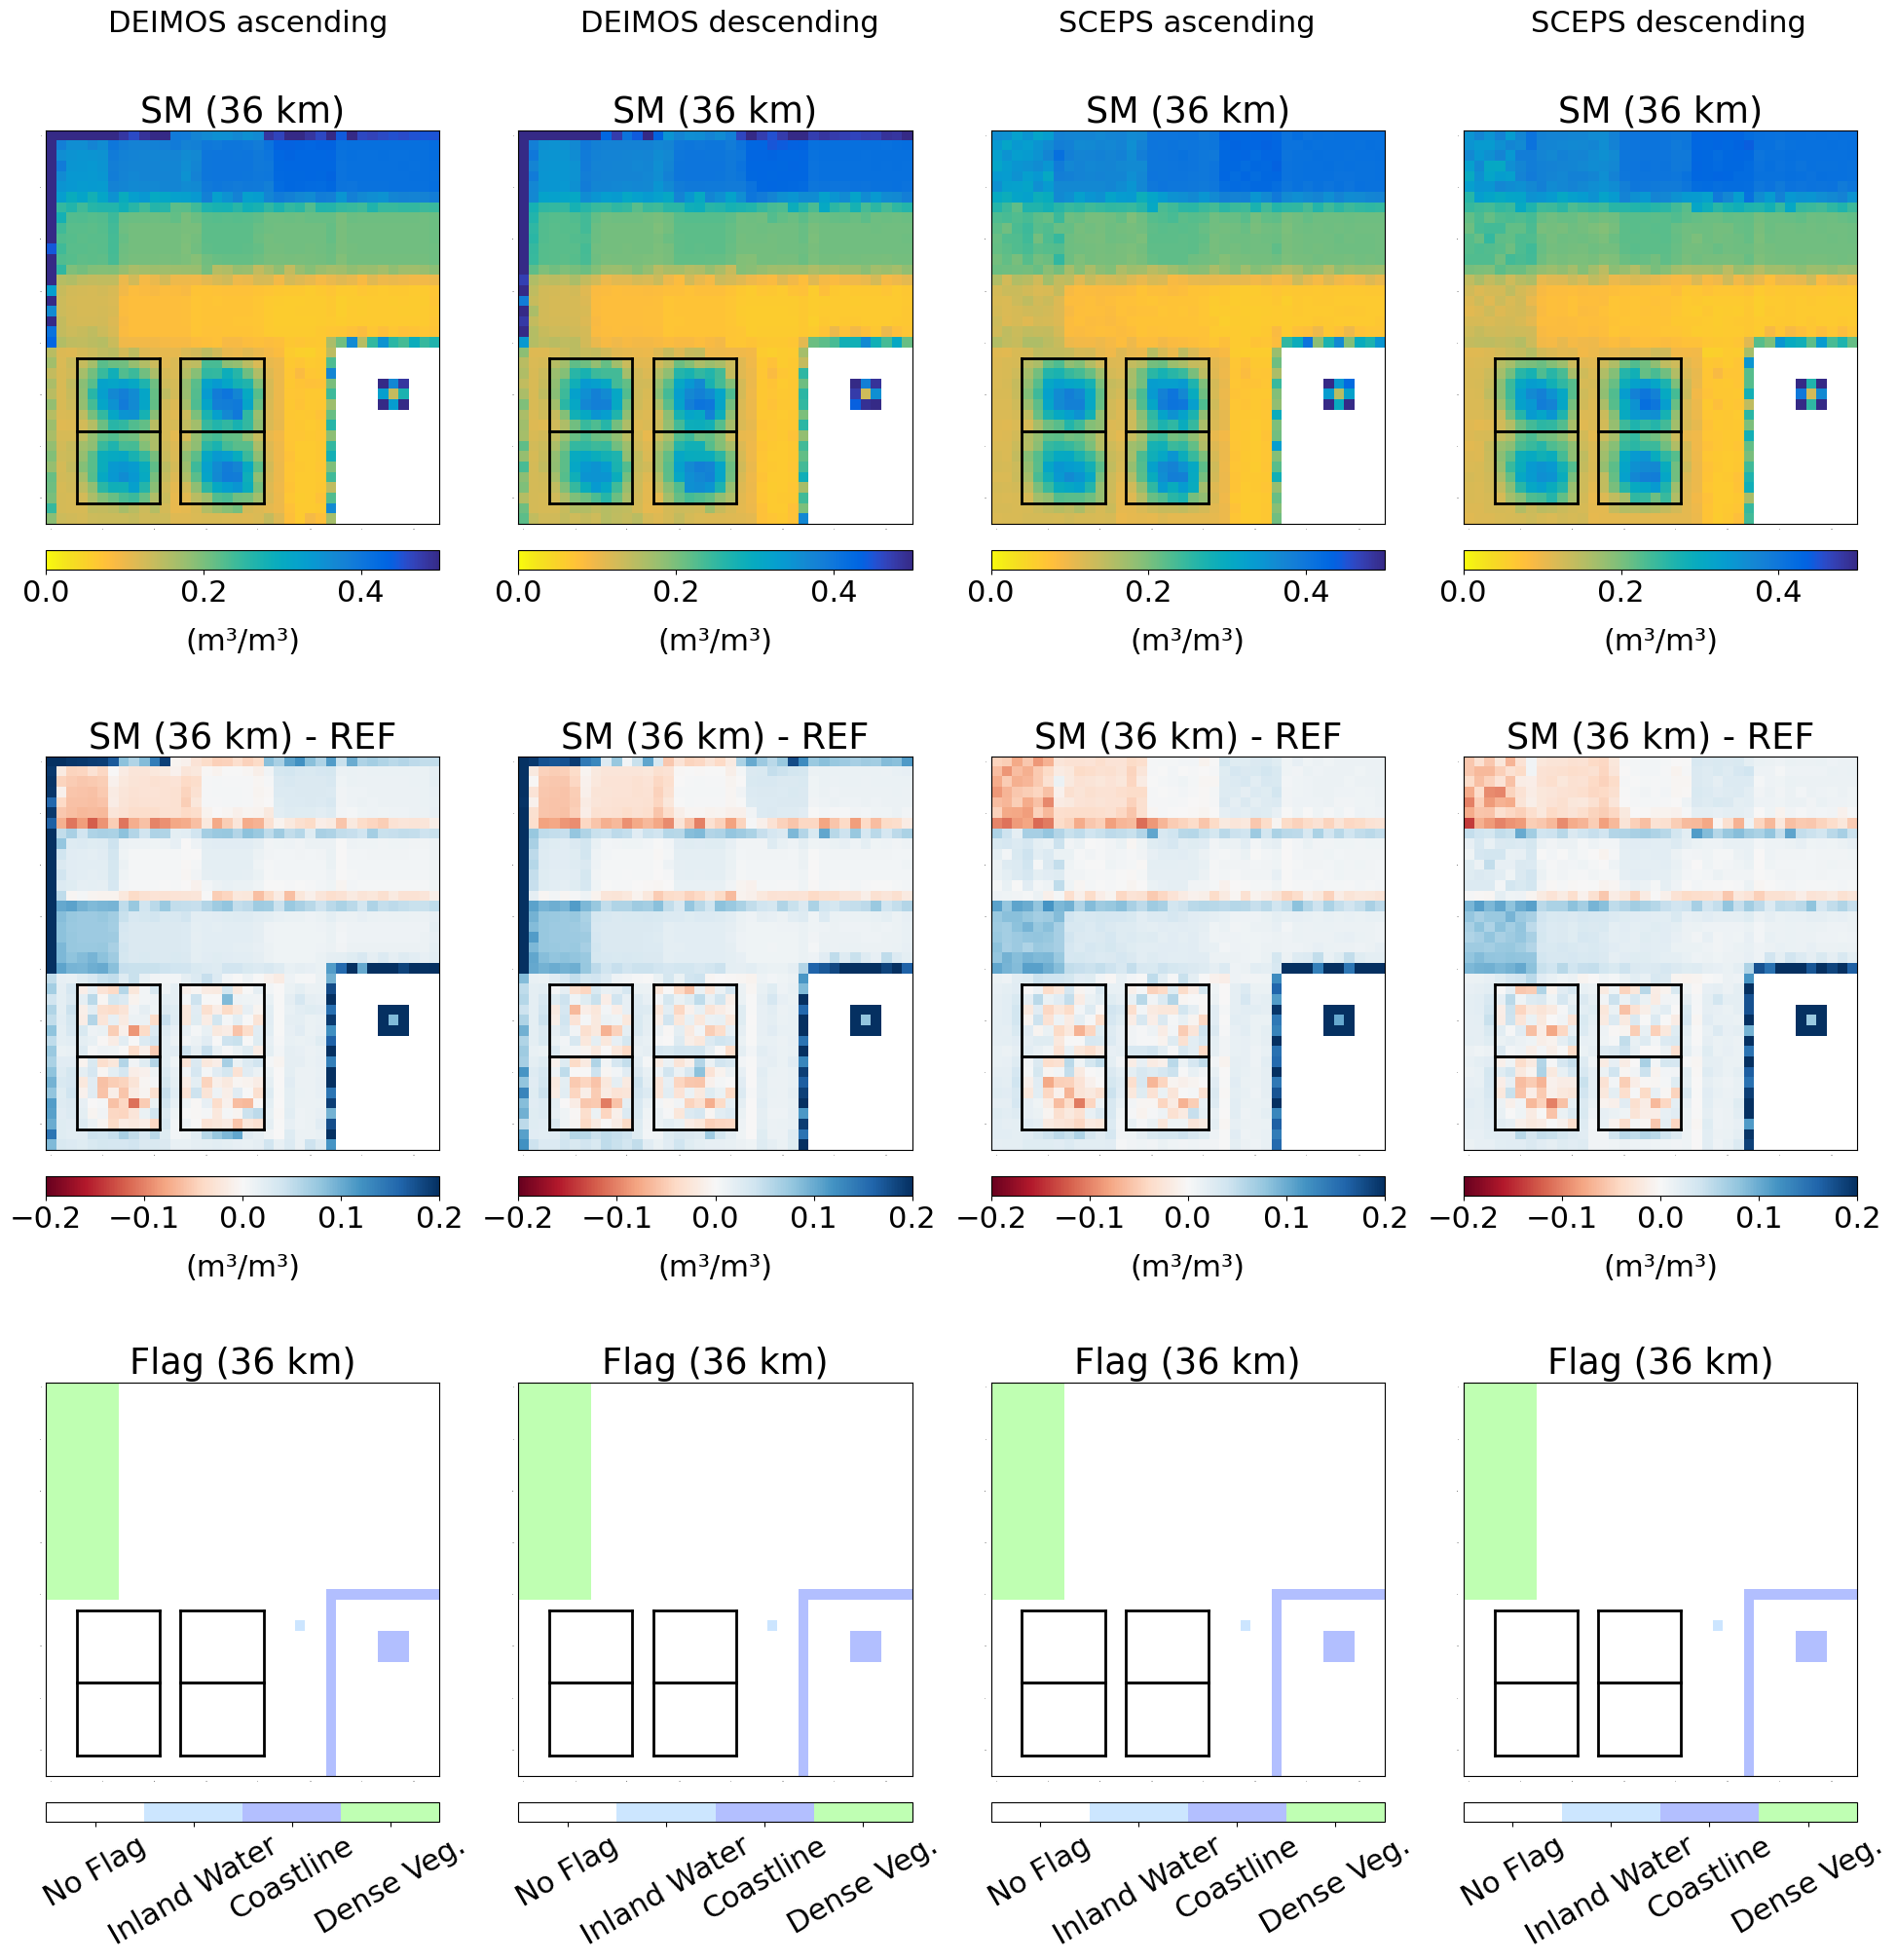

In [24]:
reload(sm_eval)

# Settings and colormaps
cmap_flags = matplotlib.colors.ListedColormap([[1, 1, 1], [0.9, 0.95, 1], [0.8, 0.85, 1], [0.85, 1, 0.8]])
leg_flag = ['No Flag', 'Water Fract', 'Coastline', 'Vegetation']
filenames = ['DEIMOS ascending', 'DEIMOS descending', 'SCEPS ascending', 'SCEPS descending']

# 36 km
reference = tc_36['Soil Moisture']
deimos_asc = l2_36_deimos_asc
deimos_des = l2_36_deimos_des
sceps_asc = l2_36_sceps_asc
sceps_des = l2_36_sceps_des
plot_range = [0.0, 0.5]
plot_range_diff = [-0.2, 0.2]
plt_range_flags = [0, 4]
grid = 36


# Plot
gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1, 1])
fig = plt.figure(figsize=(6*4, 8*4))
# SM
ax = fig.add_subplot(gs[0, 0])
sm_eval.plot_sm(deimos_asc['soil_moisture'].data[0, :, :], 'SM (36 km)', grid, plot_range, None)
plt.text(5.5, -10, filenames[0])
ax = fig.add_subplot(gs[0, 1])
sm_eval.plot_sm(deimos_des['soil_moisture'].data[0, :, :], 'SM (36 km)', grid, plot_range, None)
plt.text(5.5, -10, filenames[1])
ax = fig.add_subplot(gs[0, 2])
sm_eval.plot_sm(sceps_asc['soil_moisture'].data[0, :, :], 'SM (36 km)', grid, plot_range, None)
plt.text(6, -10, filenames[2])
ax = fig.add_subplot(gs[0, 3])
sm_eval.plot_sm(sceps_des['soil_moisture'].data[0, :, :], 'SM (36 km)', grid, plot_range, None)
plt.text(6, -10, filenames[3])
# DELTA
ax = fig.add_subplot(gs[1, 0])
sm_eval.plot_sm_diff(reference, deimos_asc['soil_moisture'].data[0, :, :], 'SM (36 km) - REF', grid, plot_range_diff, 'RdBu')
ax = fig.add_subplot(gs[1, 1])
sm_eval.plot_sm_diff(reference, deimos_des['soil_moisture'].data[0, :, :], 'SM (36 km) - REF', grid, plot_range_diff, 'RdBu')
ax = fig.add_subplot(gs[1, 2])
sm_eval.plot_sm_diff(reference, sceps_asc['soil_moisture'].data[0, :, :], 'SM (36 km) - REF', grid, plot_range_diff, 'RdBu')
ax = fig.add_subplot(gs[1, 3])
sm_eval.plot_sm_diff(reference, sceps_des['soil_moisture'].data[0, :, :], 'SM (36 km) - REF', grid, plot_range_diff, 'RdBu')
# Flags
ax = fig.add_subplot(gs[2, 0])
sm_eval.plot_flag(deimos_asc['retrieval_scene_flag'].data[0, :, :], deimos_asc['retrieval_status_flag'].data[0, :, :], 'Flag (36 km)', grid)
ax = fig.add_subplot(gs[2, 1])
sm_eval.plot_flag(deimos_des['retrieval_scene_flag'].data[0, :, :], deimos_des['retrieval_status_flag'].data[0, :, :], 'Flag (36 km)', grid)
ax = fig.add_subplot(gs[2, 2])
sm_eval.plot_flag(sceps_asc['retrieval_scene_flag'].data[0, :, :], sceps_asc['retrieval_status_flag'].data[0, :, :], 'Flag (36 km)', grid)
ax = fig.add_subplot(gs[2, 3])
sm_eval.plot_flag(sceps_des['retrieval_scene_flag'].data[0, :, :], sceps_des['retrieval_status_flag'].data[0, :, :], 'Flag (36 km)', grid)
# adjust
plt.subplots_adjust(wspace=0.2, hspace=0.2)


### 2.2. Soil moisture retrievals at the 9 km grid

We show soil moisture retrievals and errors (error = retrieval - reference) at the 9 km grid. Similar to the 36 km retrievals, we find that the 9 km retrievals capture soil moisture patterns well across different land use classes and scales. The error patterns across the test card are explained in section 2.1., which is not repeated here.

Two additional observations apply only to 9 km retrievals: Edge effects are visible in the northeastern area of the test card, which is an artifact resulting from the sharp land cover transitions in the synthetic test card. Also, additional error patterns are visible within the AOIs compared to 36 km retrievals, which is expected from the higher resolution of the synthetic reference. A more detailed view of these patterns is given in section 2.3.

An assessment of ubRMSE and bias metrics for the AOIs is given in section 2.4.

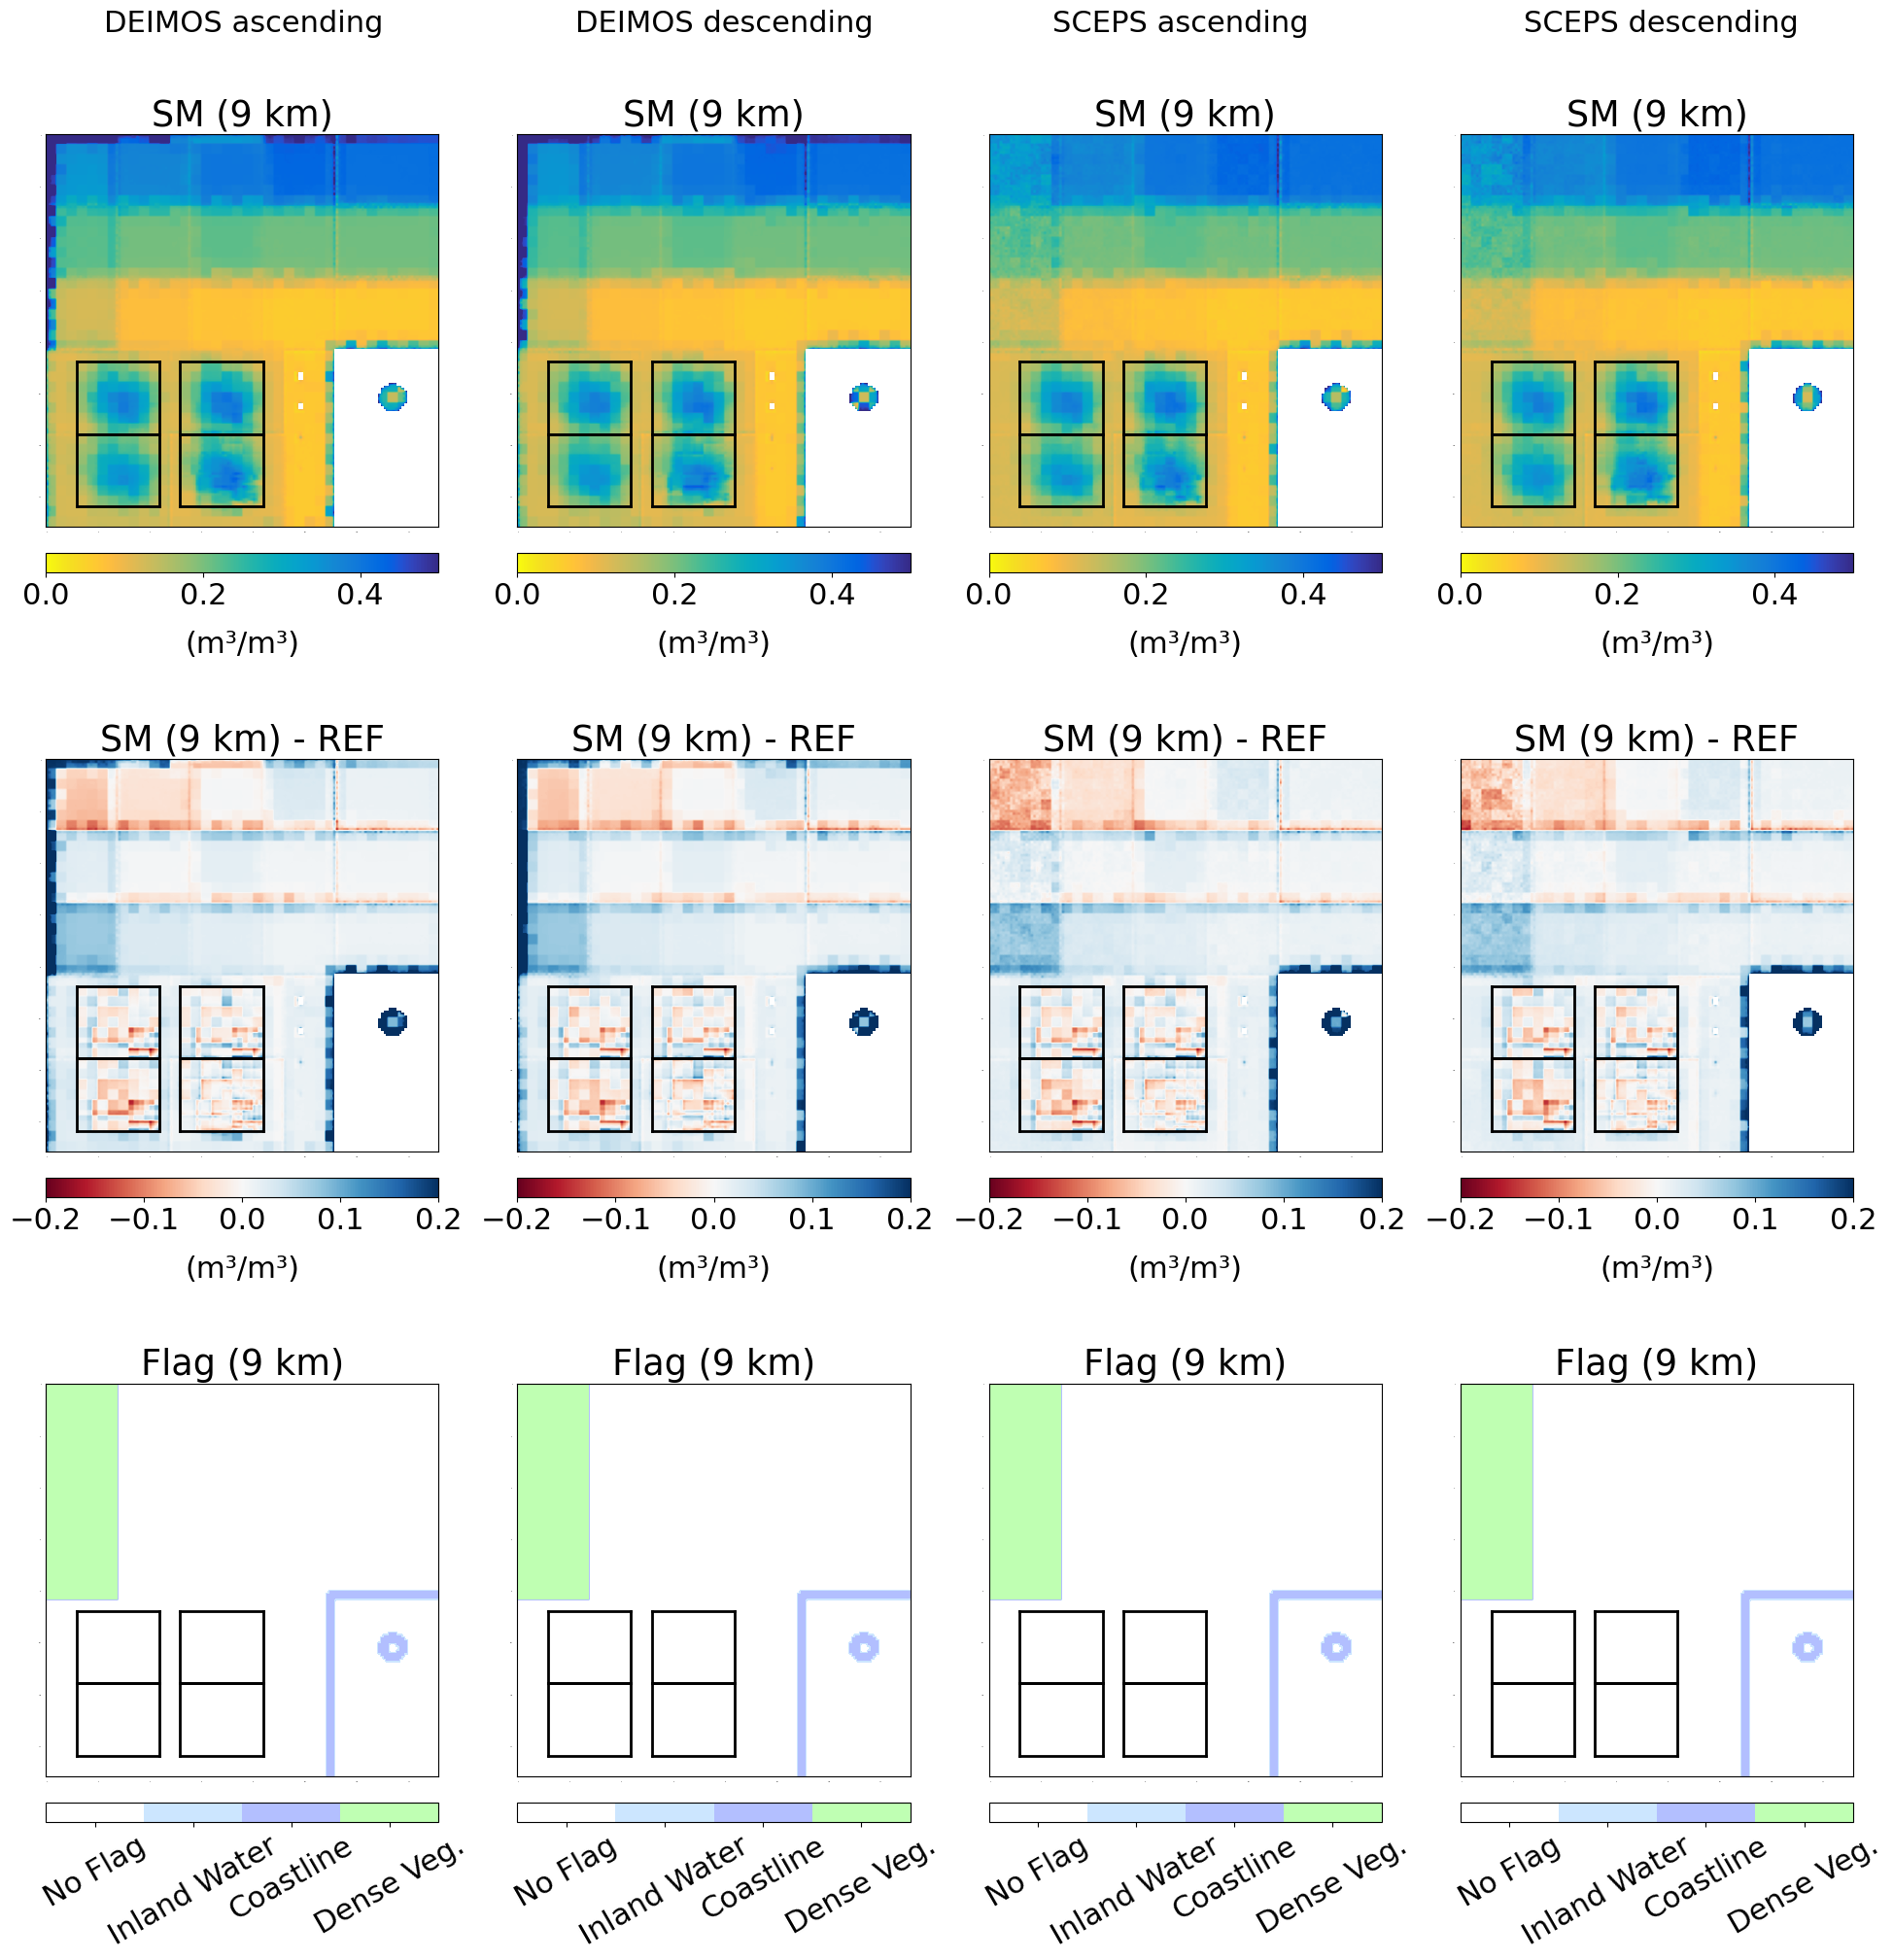

In [25]:
reload(sm_eval)

# 9 km
reference = tc_09['Soil Moisture'][:152, :152]
deimos_asc = l2_09_deimos_asc
deimos_des = l2_09_deimos_des
sceps_asc = l2_09_sceps_asc
sceps_des = l2_09_sceps_des
plot_range = [0, 0.5]
plot_range_diff = [-0.2, 0.2]
plt_range_flags = [0, 4]
grid = 9

# Plot
gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1, 1])
fig = plt.figure(figsize=(6*4, 8*4))
# SM
ax = fig.add_subplot(gs[0, 0])
sm_eval.plot_sm(deimos_asc['soil_moisture'].data[0, :, :], 'SM (9 km)', grid, plot_range)
plt.text(22, -40, filenames[0])
ax = fig.add_subplot(gs[0, 1])
sm_eval.plot_sm(deimos_des['soil_moisture'].data[0, :, :], 'SM (9 km)', grid, plot_range)
plt.text(22, -40, filenames[1])
ax = fig.add_subplot(gs[0, 2])
sm_eval.plot_sm(sceps_asc['soil_moisture'].data[0, :, :], 'SM (9 km)', grid, plot_range)
plt.text(24, -40, filenames[2])
ax = fig.add_subplot(gs[0, 3])
sm_eval.plot_sm(sceps_des['soil_moisture'].data[0, :, :], 'SM (9 km)', grid, plot_range)
plt.text(24, -40, filenames[3])
# DELTA
ax = fig.add_subplot(gs[1, 0])
sm_eval.plot_sm_diff(reference, deimos_asc['soil_moisture'].data[0, :, :], 'SM (9 km) - REF', grid, plot_range_diff, 'RdBu')
ax = fig.add_subplot(gs[1, 1])
sm_eval.plot_sm_diff(reference, deimos_des['soil_moisture'].data[0, :, :], 'SM (9 km) - REF', grid, plot_range_diff, 'RdBu')
ax = fig.add_subplot(gs[1, 2])
sm_eval.plot_sm_diff(reference, sceps_asc['soil_moisture'].data[0, :, :], 'SM (9 km) - REF', grid, plot_range_diff, 'RdBu')
ax = fig.add_subplot(gs[1, 3])
sm_eval.plot_sm_diff(reference, sceps_des['soil_moisture'].data[0, :, :], 'SM (9 km) - REF', grid, plot_range_diff, 'RdBu')
# Flags
ax = fig.add_subplot(gs[2, 0])
sm_eval.plot_flag(deimos_asc['retrieval_scene_flag'].data[0, :, :], deimos_asc['retrieval_status_flag'].data[0, :, :], 'Flag (9 km)', grid)
ax = fig.add_subplot(gs[2, 1])
sm_eval.plot_flag(deimos_des['retrieval_scene_flag'].data[0, :, :], deimos_des['retrieval_status_flag'].data[0, :, :], 'Flag (9 km)', grid)
ax = fig.add_subplot(gs[2, 2])
sm_eval.plot_flag(sceps_asc['retrieval_scene_flag'].data[0, :, :], sceps_asc['retrieval_status_flag'].data[0, :, :], 'Flag (9 km)', grid)
ax = fig.add_subplot(gs[2, 3])
sm_eval.plot_flag(sceps_des['retrieval_scene_flag'].data[0, :, :], sceps_des['retrieval_status_flag'].data[0, :, :], 'Flag (9 km)', grid)
# adjust
plt.subplots_adjust(wspace=0.2, hspace=0.2)

### 2.3. Comparison of 36 km and 9 km retrievals

A more detailed view of the 36 km and 9 km retrievals is given below. 

At the 36 km grid, soil moisture patterns are reasonably captured by the retrievals. Note that the retrievals do not capture the full spatial dynamic range of the reference in all cases, which is expected as the L-band footprint of CIMR is significantly larger than the 36 km grid, and a simple Gaussian regridding was applied in this prototype implementation. It is expected that more advanced regridding techniques can further improve the capabilities to capture spatial patterns at the 36 km scale. The dry bias observed over the mixed land use class (bottom left AOI) is likely related to vegetation masking of the soil signal, which further reduces the dynamic range of the observed TBs.

At the 9 km grid, the high resolution reference soil moisture patterns are captured particularly well for bare soil (bottom right AOI) and grassland (top right AOI). This is expected as the C-band signal from the soil gets increasingly masked with increasing vegetation cover. Note that the synthetic test card assessed here does not show spatial land cover variability at the 9 km scale, which limits the available brightness temperature variability to be captured by the sharpening algorithm. It is expected that the added value of the sharpening would increase further for scenes that include spatial land cover heterogeneity.

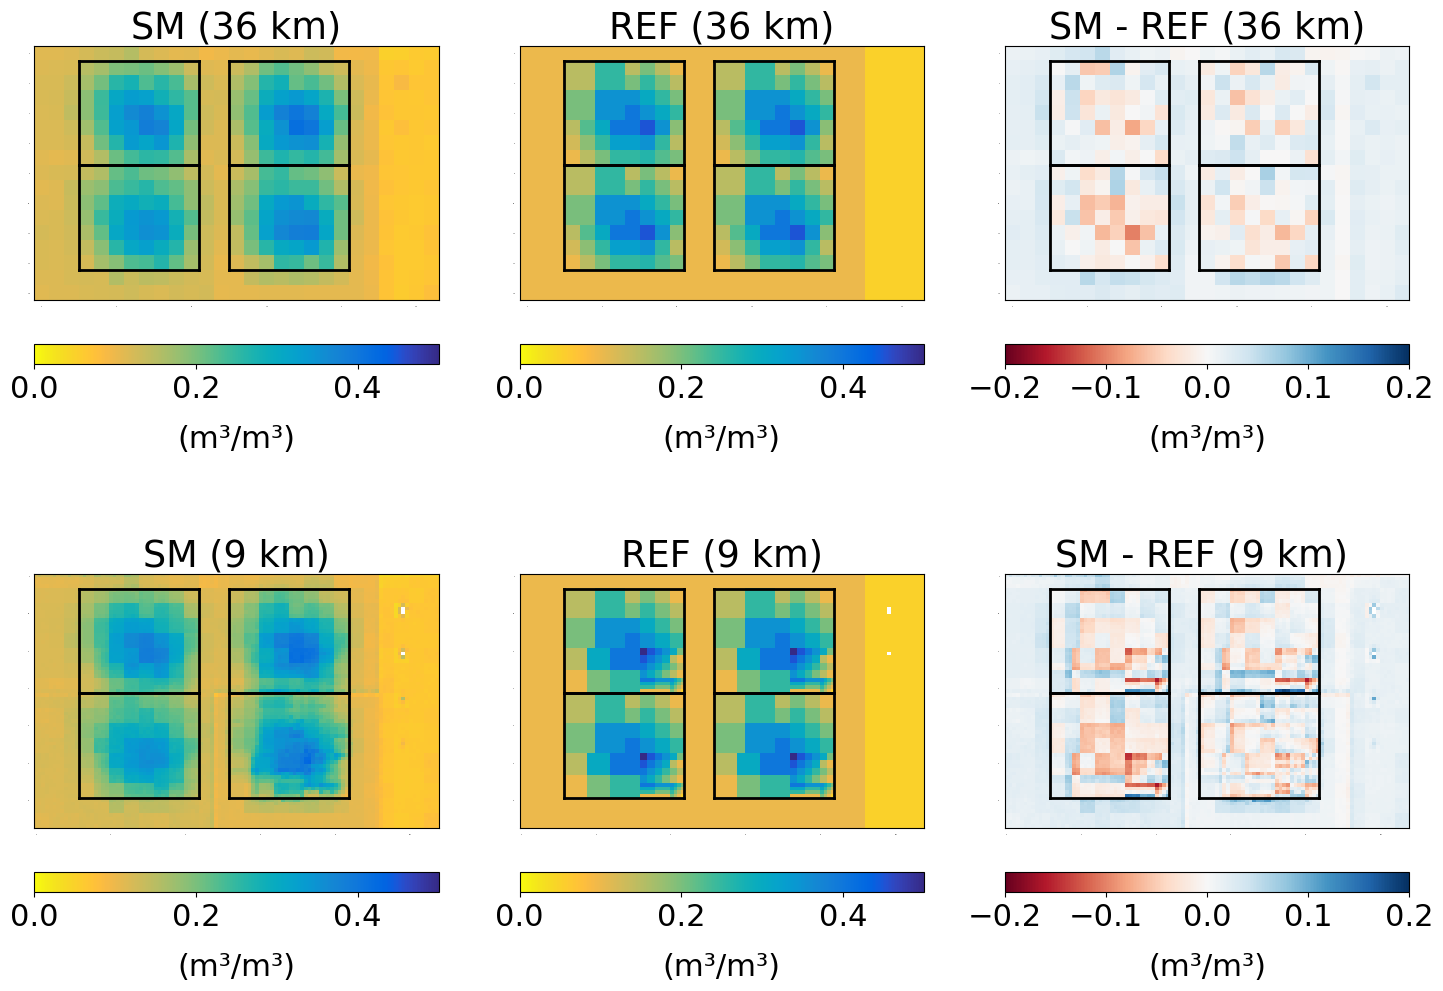

In [54]:
reload(sm_eval)

# Compare 36 km and 9 km retrievals
ref_36 = tc_36['Soil Moisture']
ref_09 = tc_09['Soil Moisture'][:152, :152]
sm_09 = l2_09_sceps_des['soil_moisture'].data[0, :, :]
sm_36 = l2_36_sceps_des['soil_moisture'].data[0, :, :]
plot_range = [0, 0.5]
plot_range_diff = [-0.2, 0.2]

# Plot
gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1, 1])
fig = plt.figure(figsize=(6*4, 8*4))
# 36 km
ax = fig.add_subplot(gs[0, 0])
sm_eval.plot_sm(sm_36, 'SM (36 km)', 36, plot_range, None, zoom=True)
ax = fig.add_subplot(gs[0, 1])
sm_eval.plot_tc(ref_36, 'REF', 36, plot_range, None, zoom=True)
ax = fig.add_subplot(gs[0, 2])
sm_eval.plot_sm_diff(ref_36, sm_36, 'SM - REF (36 km)', 36, plot_range_diff, 'RdBu', zoom=True)
# 9 km
ax = fig.add_subplot(gs[1, 0])
sm_eval.plot_sm(sm_09, 'SM (9 km)', 9, plot_range, None, zoom=True)
ax = fig.add_subplot(gs[1, 1])
sm_eval.plot_tc(ref_09, 'REF', 9, plot_range, None, zoom=True)
ax = fig.add_subplot(gs[1, 2])
sm_eval.plot_sm_diff(ref_09, sm_09, 'SM - REF (9 km) ', 9, plot_range_diff, 'RdBu', zoom=True)
# adjust
plt.subplots_adjust(wspace=0.2, hspace=-0.4)


### 2.4. ubRMSE and bias

We consider two performance assessment metrics: the unbiased root mean square error (ubRMSE) and bias. The metrics are calculated for the four AOIs, which correspond to land use classes of bare soil, grassland, cropland, and mixed land use. AOIs are indicated as black boxes in all figures.

The metrics are calculated for the 36 km and 9 km retrievals. For a fair comparison, the soil moisture reference is gridded to the same scale as the corresponding L2 product.  

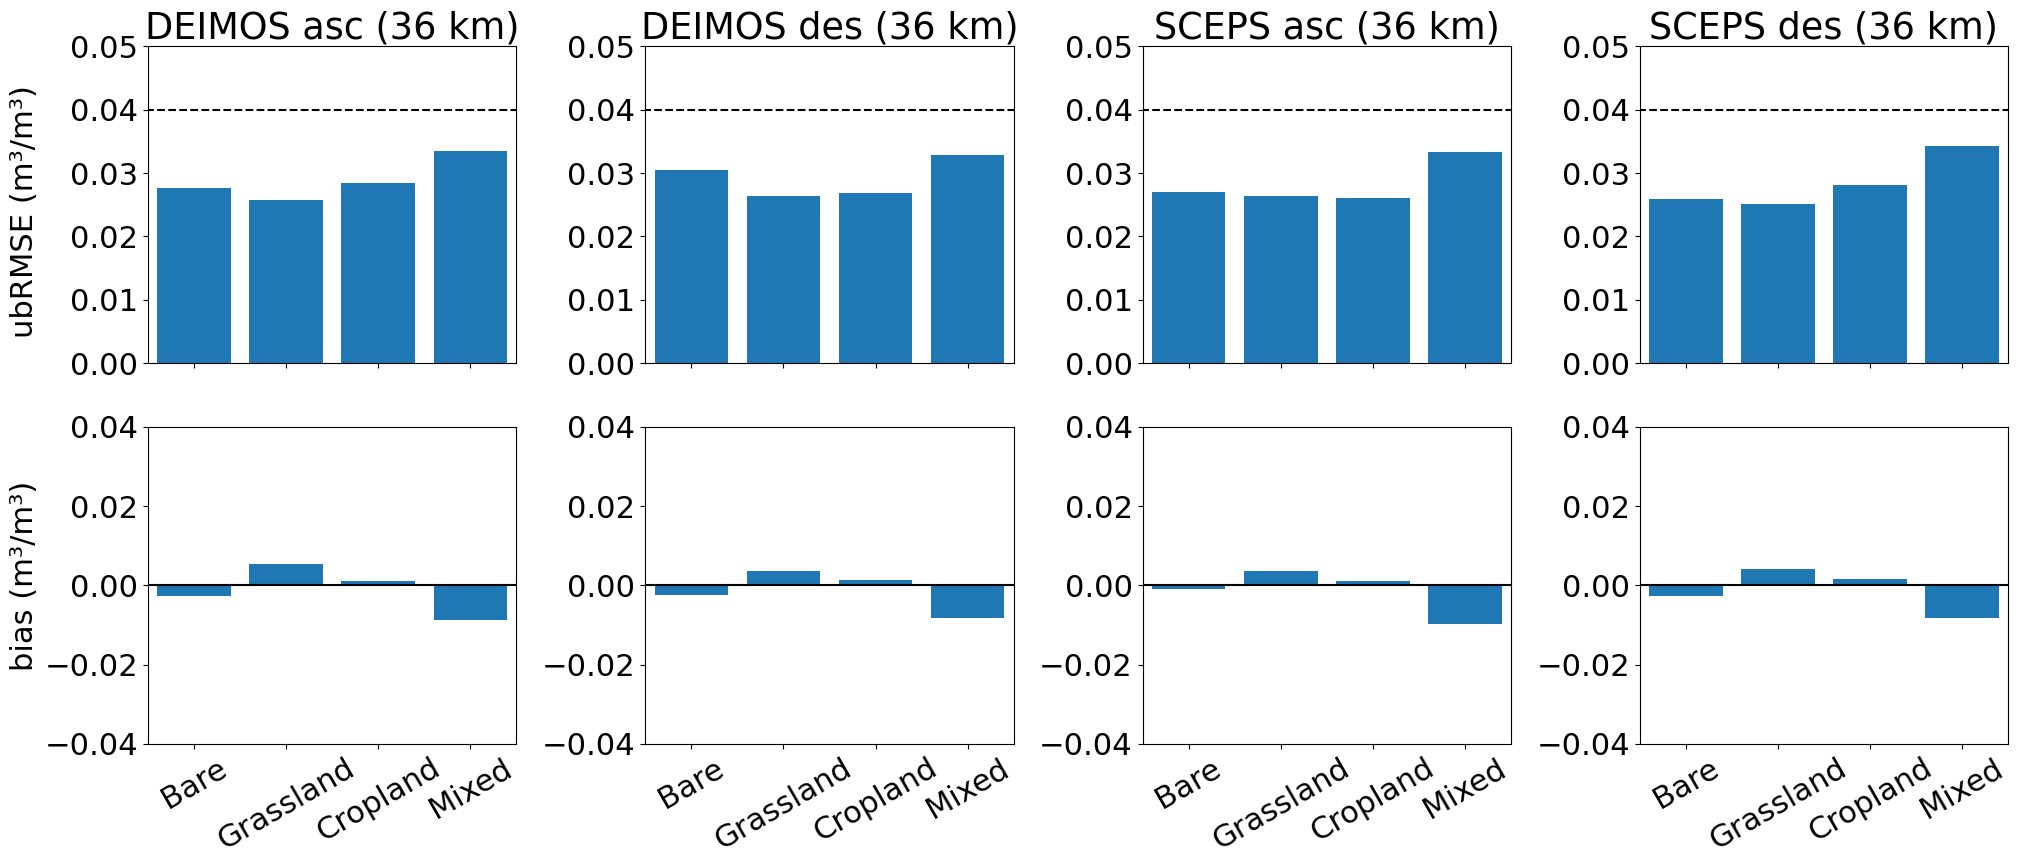

In [29]:
reload(sm_eval)

# Metrics for 36 km retrievals
reference = tc_36['Soil Moisture']
deimos_asc = l2_36_deimos_asc['soil_moisture'].data[0, :, :]
deimos_des = l2_36_deimos_des['soil_moisture'].data[0, :, :]
sceps_asc = l2_36_sceps_asc['soil_moisture'].data[0, :, :]
sceps_des = l2_36_sceps_des['soil_moisture'].data[0, :, :]
grid = 36

# Plot
gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1])
fig = plt.figure(figsize=(24, 14))
# ubRMSE
label = 'ubRMSE (m³/m³)'
ylimit = [0, 0.05]
yline = 0.04
linestyle = 'k--'
title = True
ticks = False
ax = fig.add_subplot(gs[0, 0])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, deimos_asc,grid), ylimit, yline, linestyle, 'DEIMOS asc (36 km)', title, ticks)
plt.text(-2, 0.005, 'ubRMSE (m³/m³)', rotation=90)
ax = fig.add_subplot(gs[0, 1])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, deimos_des,grid), ylimit, yline, linestyle, 'DEIMOS des (36 km)', title, ticks)
ax = fig.add_subplot(gs[0, 2])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, sceps_asc,grid), ylimit, yline, linestyle, 'SCEPS asc (36 km)', title, ticks)
ax = fig.add_subplot(gs[0, 3])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, sceps_des,grid), ylimit, yline, linestyle, 'SCEPS des (36 km)', title, ticks)
# Bias
label = 'Bias (m³/m³)'
ylimit = [-0.04, 0.04]
yline = 0.0
linestyle = 'k-'
title = False
ticks = True
ax = fig.add_subplot(gs[1, 0])
sm_eval.barplot(sm_eval.bias_aoi(reference, deimos_asc,grid), ylimit, yline, linestyle, 'DEIMOS asc', title, ticks)
plt.text(-2, -0.02, 'bias (m³/m³)', rotation=90)
ax = fig.add_subplot(gs[1, 1])
sm_eval.barplot(sm_eval.bias_aoi(reference, deimos_des,grid), ylimit, yline, linestyle, 'DEIMOS des', title, ticks)
ax = fig.add_subplot(gs[1, 2])
sm_eval.barplot(sm_eval.bias_aoi(reference, sceps_asc,grid), ylimit, yline, linestyle, 'DEIMOS asc', title, ticks)
ax = fig.add_subplot(gs[1, 3])
sm_eval.barplot(sm_eval.bias_aoi(reference, sceps_des,grid), ylimit, yline, linestyle, 'DEIMOS asc', title, ticks)
# adjust
plt.subplots_adjust(wspace=0.35, hspace=0.2)


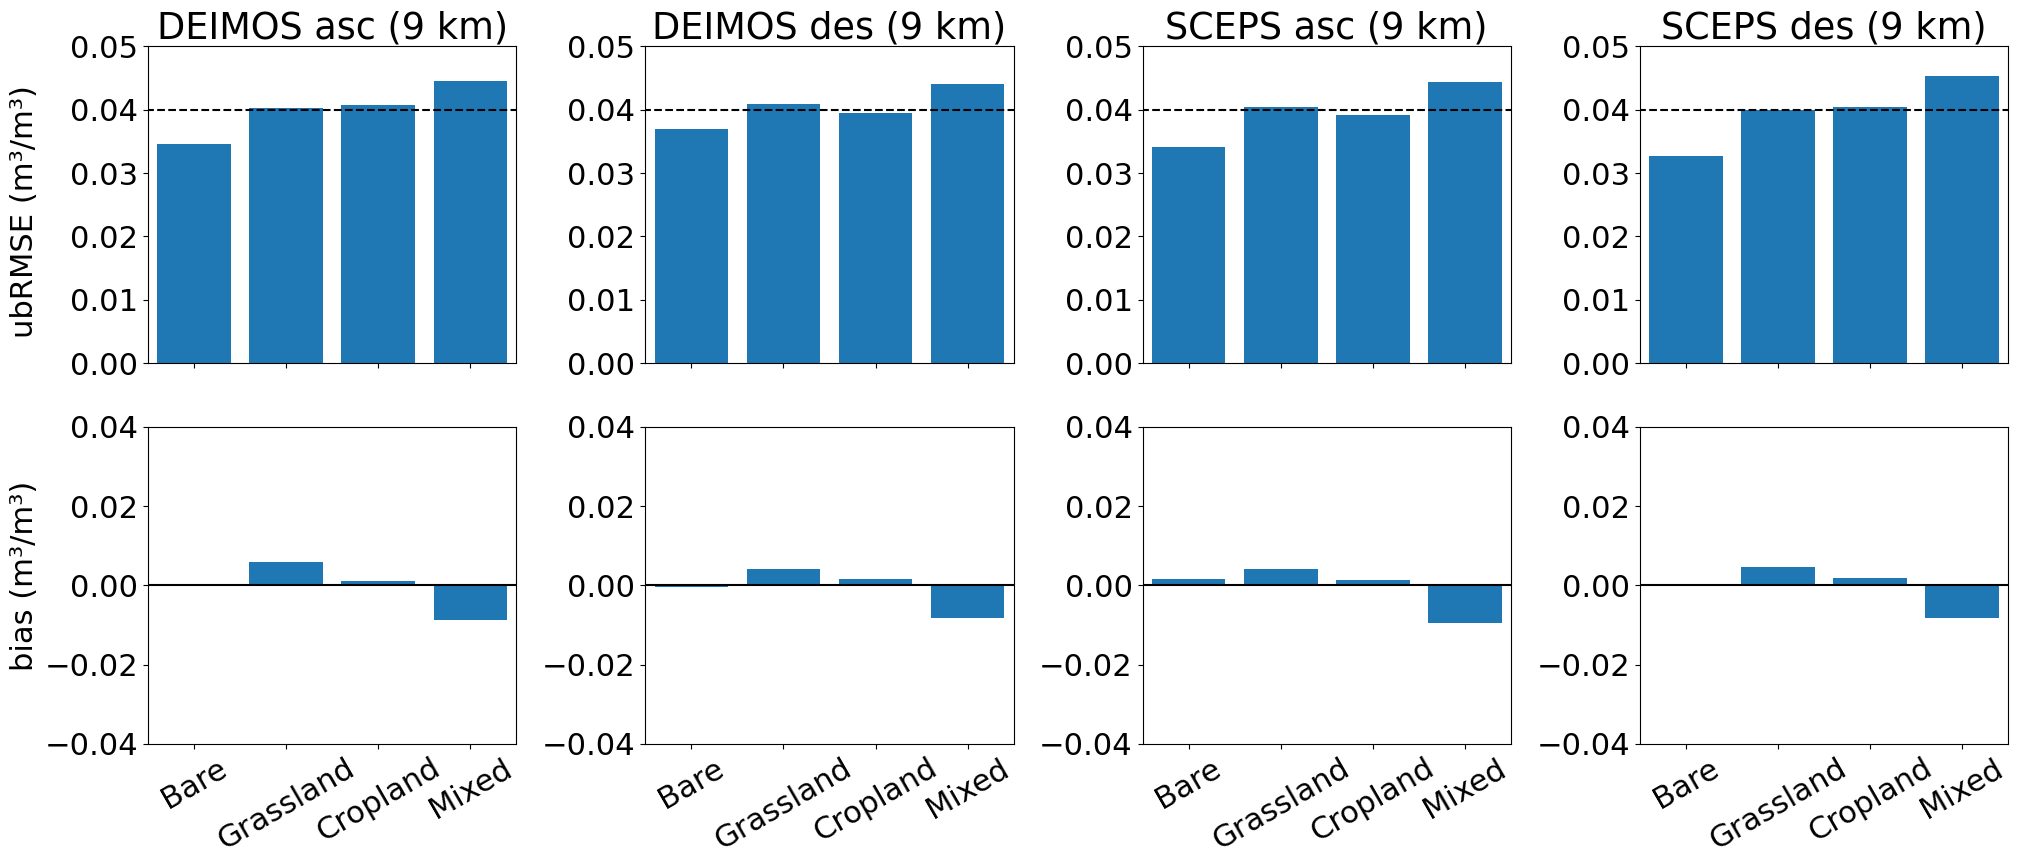

In [30]:
reload(sm_eval)

# Metrics for 9 km retrievals
reference = tc_09['Soil Moisture'][:152, :152]
deimos_asc = l2_09_deimos_asc['soil_moisture'].data[0, :, :]
deimos_des = l2_09_deimos_des['soil_moisture'].data[0, :, :]
sceps_asc = l2_09_sceps_asc['soil_moisture'].data[0, :, :]
sceps_des = l2_09_sceps_des['soil_moisture'].data[0, :, :]
grid = 9

# Plot
gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1])
fig = plt.figure(figsize=(24, 14))
# ubRMSE
label = 'ubRMSE (m³/m³)'
ylimit = [0, 0.05]
yline = 0.04
linestyle = 'k--'
title = True
ticks = False
ax = fig.add_subplot(gs[0, 0])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, deimos_asc, grid), ylimit, yline, linestyle, 'DEIMOS asc (9 km)', title, ticks)
plt.text(-2, 0.005, 'ubRMSE (m³/m³)', rotation=90)
ax = fig.add_subplot(gs[0, 1])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, deimos_des, grid), ylimit, yline, linestyle, 'DEIMOS des (9 km)', title, ticks)
ax = fig.add_subplot(gs[0, 2])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, sceps_asc, grid), ylimit, yline, linestyle, 'SCEPS asc (9 km)', title, ticks)
ax = fig.add_subplot(gs[0, 3])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, sceps_des, grid), ylimit, yline, linestyle, 'SCEPS des (9 km)', title, ticks)
# Bias
label = 'Bias (m³/m³)'
ylimit = [-0.04, 0.04]
yline = 0.0
linestyle = 'k-'
title = False
ticks = True
ax = fig.add_subplot(gs[1, 0])
sm_eval.barplot(sm_eval.bias_aoi(reference, deimos_asc, grid), ylimit, yline, linestyle, 'DEIMOS asc', title, ticks)
plt.text(-2, -0.02, 'bias (m³/m³)', rotation=90)
ax = fig.add_subplot(gs[1, 1])
sm_eval.barplot(sm_eval.bias_aoi(reference, deimos_des, grid), ylimit, yline, linestyle, 'DEIMOS des', title, ticks)
ax = fig.add_subplot(gs[1, 2])
sm_eval.barplot(sm_eval.bias_aoi(reference, sceps_asc, grid), ylimit, yline, linestyle, 'DEIMOS asc', title, ticks)
ax = fig.add_subplot(gs[1, 3])
sm_eval.barplot(sm_eval.bias_aoi(reference, sceps_des, grid), ylimit, yline, linestyle, 'DEIMOS asc', title, ticks)
# adjust
plt.subplots_adjust(wspace=0.35, hspace=0.2)


## Summary and Observations

We present a performance evaluation of a prototype L2 soil moisture retrieval algorithm for CIMR. The algorithm parameters have not been calibrated prior to the evaluation. All parameters are based on the initial proposal in the CIMR soil moisture prototype ATBD.

Observations:
- At the 36 km scale, the algorithm shows an ubRMSE < 0.04 m³/m³.
- At the 9 km scale, the algorithm shows an ubRMSE between 0.035-0.045 m³/m³.
- Errors generally increase with increasing vegetation cover, in accordance with expectations.
- Biases are overall low and do not exceed 0.01 m³/m³.
- The results are consistent across overpasses.
